# SRGAN 활용하기

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

프로젝트 1.1
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러온다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄인다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이비지를 생성.
4. bicubic interpolation 이용해서 다시 가로 및 세로 픽셀 수를 4배로 늘린다.
5. 3개의 이미지를 나란히 시각화
6. 선택한 이미지를 DIVI2K 데이터셋에서 학습한 모델로 super resolution 했을 때 결과 분석

(779, 680, 3)


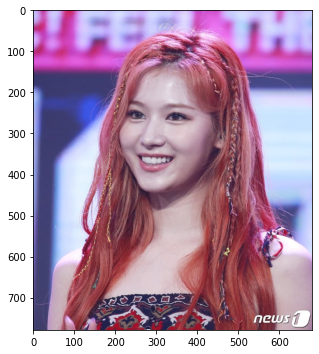

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import os

hr = cv2.imread(os.getenv('HOME') + '/aiffel/SRGAN/sana.jpg')
hr = cv2.cvtColor(hr, cv2.COLOR_BGR2RGB)
print(hr.shape)
plt.figure(figsize = (5, 10))
plt.imshow(hr)    

(194, 170, 3)


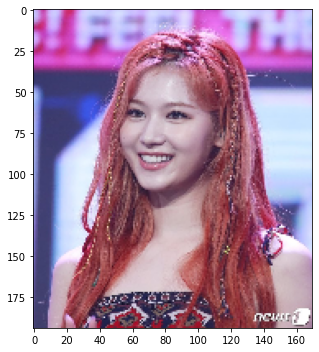

In [11]:
# bicubic interpolation으로 1/4로 줄였다.
bicubic_lr = cv2.resize(
    hr, 
    dsize=(hr.shape[1]//4, hr.shape[0]//4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

print(bicubic_lr.shape)

plt.figure(figsize = (5, 10))
plt.imshow(bicubic_lr)

In [13]:
import tensorflow as tf

#사전에 이미 학습이 완료 된 SRGAN 모델 로드
model_file = os.getenv('HOME')+'/aiffel/SRGAN/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [14]:
# 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

srgan_hr = apply_srgan(bicubic_lr)

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling div2k-train.tfrecord...:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling div2k-validation.tfrecord...:   0%|          | 0/100 [00:00<?, ? examples/s]

Dataset div2k downloaded and prepared to /aiffel/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [15]:
#bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘림.

bicubic_hr = cv2.resize(
    bicubic_lr, 
    dsize=(hr.shape[1], hr.shape[0]), #고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC #bicubic 설정
)

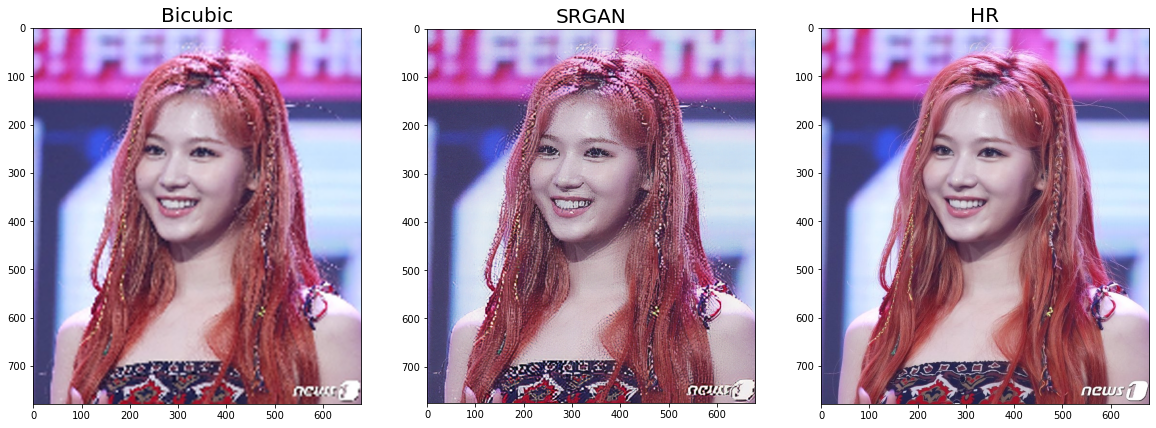

In [17]:
#Bicubic의 결과, SRGAN의 결과, 원래 고해상도 이미지를 나란히 시각화

images = [bicubic_hr, srgan_hr, hr]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(20,10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [18]:
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

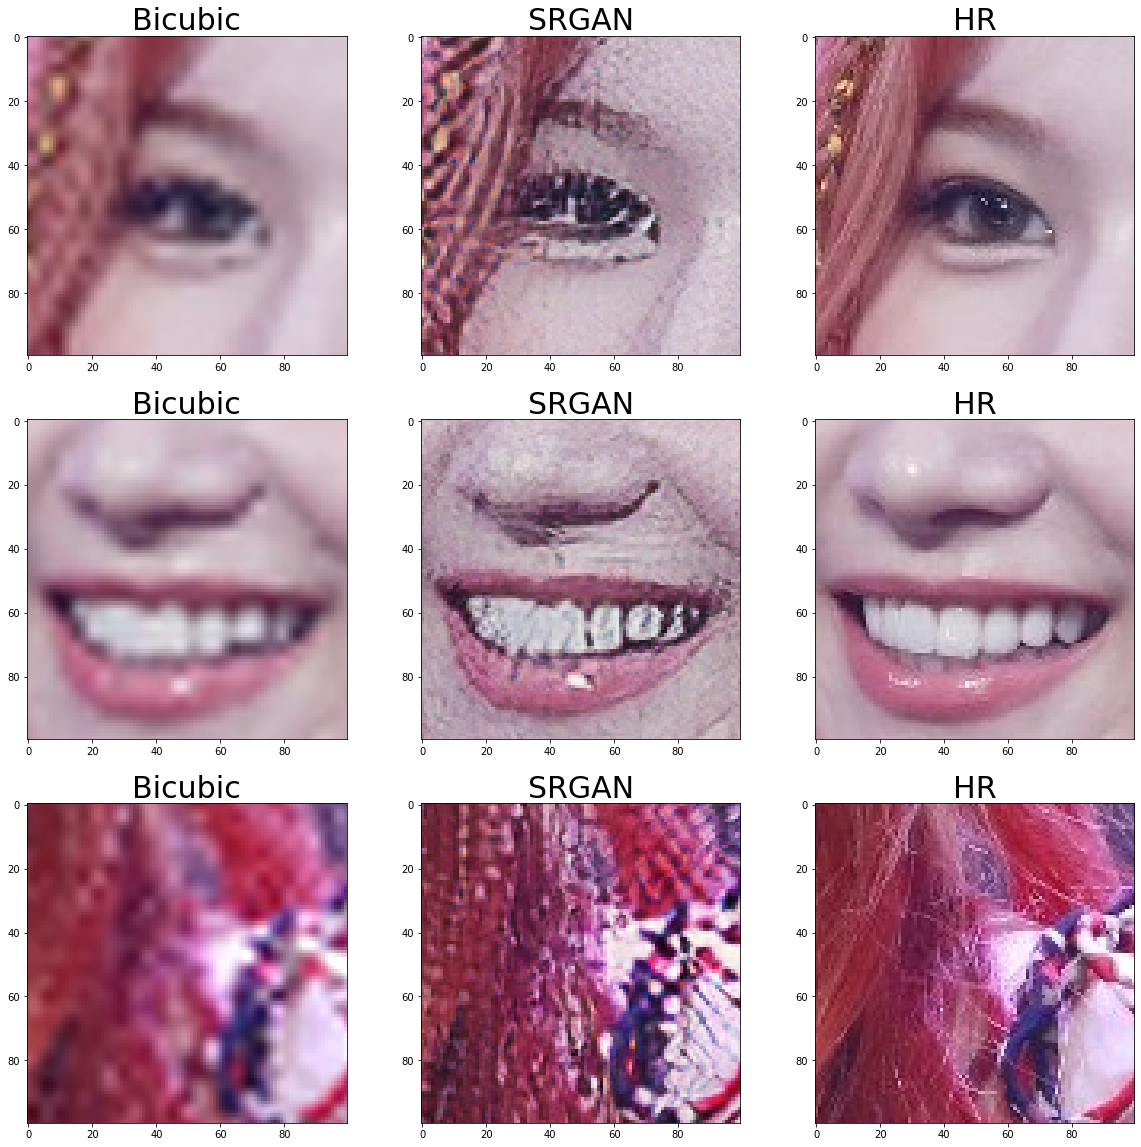

In [29]:
#자세히 시각화 하기 위해 3개 영역을 잘라냄.
left_tops = [(200,200), (300, 250), (500, 500)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 100, 100)
    img2 = crop(srgan_hr , left_top, 100, 100)
    img3 = crop(hr, left_top, 100, 100)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

프로젝트 1-2
1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 저장, 불러오기
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성
3. bicubic interpolation을 적용해 픽셀 수 4배로 늘림
4. 2개 이미지 시각화
5. 선택한 이미지를 DIVI2K 데이터셋에서 학습한 모델로 super resolution 했을 때 결과 분석

(190, 266, 3)


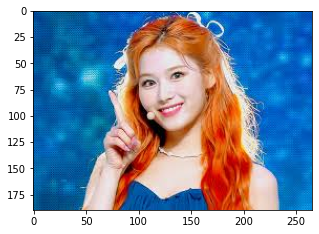

In [31]:
#저해상도 이미지 로드
image = cv2.imread(os.getenv('HOME') + '/aiffel/SRGAN/sana3.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

plt.figure(figsize=(5, 10))
plt.imshow(image)

In [32]:
# srgan 이용
srgan_hr = apply_srgan(image)

In [33]:
#bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 4배로 늘림

bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), #사이즈를 4배 늘림
    interpolation=cv2.INTER_CUBIC #bicubic 설정
)

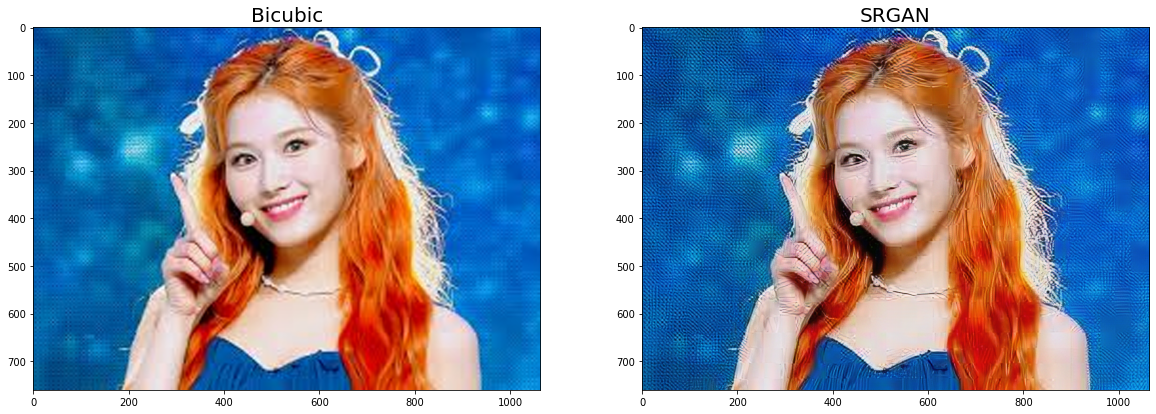

In [34]:
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(20, 10))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성

### 1. gif 파일 불러오기

In [40]:
import cv2
import os

gif = cv2.VideoCapture(os.getenv('HOME') + '/aiffel/SRGAN/sana2.gif')

isTrue = True
frames = [] #리스트 안에 각각의 프레임이 들어가게 됨.

while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 56
frame 크기 : (450, 450, 3)


### 2. 프레임별 Super Resolution 진행

In [41]:
#bicubic interpolation으로 가로, 세로 픽셀 수를 4배 늘림.
#결과를 frames_sr이라는 리스트에 넣기.

frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [43]:
#SRGAN으로 가로, 세로 픽셀 수 4배 늘림.
#결과를 frames_sr이라는 리스트에 넣기.

frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 3. 프레임을 합쳐 gif 만들기

In [44]:
import imageio

gif_dir = os.getenv('HOME') + '/aiffel/SRGAN'

imageio.mimsave(os.path.join(gif_dir, 'sana_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_dir, 'sana_hr_srgan.gif'), frames_sr_srgan)

### 4. Jupyter notebook에 gif 표시하기

In [46]:
from IPython.display import Image as show_gif

show_gif(os.path.join(gif_dir, 'sana.gif'), width=400)
show_gif(os.path.join(gif_dir, 'sana_hr_bicubic.gif'), width=400)
show_gif(os.path.join(gif_dir, 'sana_hr_srgan.gif'), width=400)

## 회고
 ### 프로젝트 1-1 :
 - bicubic과 srgan을 비교했을 때, bicubic은 부드러운 느낌이라면, srgan은 좀 더 선명한 느낌이지만, 눈을 크롭한 이미지를 보면 조금 부자연스러운 느낌이 든다.
 - 전반적으로 srgan을 사용했을 때 이목구비가 뚜렷하게 보이는 것 같다.
 
 
### 프로젝트 1-2 :
 - 1-1과 비슷한 결과가 나온 것 같은데, srgan이 더 고화질로 보인다.
 - 이목구비가 srgan이 좀 더 뚜렷하고, 색상도 선명해 보인다.